In [70]:
import pandas as pd

df = pd.read_csv('F1_features.csv',index_col=0)

# Start with a single decision tree

Let's start by trying to predict race winner. This is a classification task where the outcome can be "winner" or "not a winner". OF course a problem is predicted to arise, that potentially multiple drivers in a single can be classified as winners. As such one with highest confidence score shall be selected.

That means we need to modify our features a little:
- Encode all categorical variables
- Encode winner/not a winner

In the future we can add qualifying times as features too.

### Test Questions
- Does weather data help?
- Does reducing of the races by year to exclude e.g. all 20th century races, improve the F1 score?
- How much does the model suffer if we remove driver/circuit info and simply feed the starting position and past performance?

In [71]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# This function displays the splits of the tree
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [72]:
encoded_drivers = pd.get_dummies(df['driverId'],prefix='driver', dtype=float)
encoded_cicruits = pd.get_dummies(df['circuitId'],prefix='circuit', dtype=float)
encoded_cicruits_m1 = pd.get_dummies(df['circuitId_m1'],prefix='circuit_m1', dtype=float)
encoded_cicruits_m2 = pd.get_dummies(df['circuitId_m2'],prefix='circuit_m2', dtype=float)
encoded_cicruits_m3 = pd.get_dummies(df['circuitId_m3'],prefix='circuit_m3', dtype=float)
encoded_cicruits_m4 = pd.get_dummies(df['circuitId_m4'],prefix='circuit_m4', dtype=float)
encoded_cicruits_m5 = pd.get_dummies(df['circuitId_m5'],prefix='circuit_m5', dtype=float)


In [73]:
winner = (df['position'] == 1).astype(int)
winner.rename('winner',inplace=True)
winner.head()

0    1
1    0
2    0
3    0
4    0
Name: winner, dtype: int64

In [74]:
features = pd.concat([df, encoded_drivers, encoded_cicruits, encoded_cicruits_m1, encoded_cicruits_m2, encoded_cicruits_m3, encoded_cicruits_m4, encoded_cicruits_m5, winner],axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 0 to 30607
Columns: 1322 entries, grid to winner
dtypes: float64(1310), int64(12)
memory usage: 308.9 MB


In [75]:
features.head()

,grid,position,driverId,position_m1,position_m2,position_m3,position_m4,position_m5,circuitId,round,...,circuit_m5_69,circuit_m5_70,circuit_m5_71,circuit_m5_73,circuit_m5_75,circuit_m5_76,circuit_m5_77,circuit_m5_78,circuit_m5_79,winner
0,1,1,1,7.0,-1.0,1.0,4.0,2.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5,2,2,6.0,7.0,14.0,5.0,4.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,7,3,3,4.0,16.0,-1.0,6.0,6.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,11,4,4,3.0,2.0,-1.0,3.0,1.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3,5,5,-1.0,9.0,2.0,8.0,7.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


You can tell there is **A LOT** of columns. Thats because there were tons of different drivers on many different circuits over the 70 odd years.

In [76]:
# Check class balance - we expect about 5% winners and 95% not, given that about 20 drivers race and only one wins.
features['winner'].value_counts()

winner
0    28900
1     1708
Name: count, dtype: int64

5.6% - not bad of a guess!

In [77]:
short_feats = features.drop(['driverId', 'circuitId', 'position', 'circuitId_m1', 'circuitId_m2', 'circuitId_m3', 'circuitId_m4', 'circuitId_m5'], 
                            axis=1)
short_feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 0 to 30607
Columns: 1314 entries, grid to winner
dtypes: float64(1310), int64(4)
memory usage: 307.1 MB


In [78]:
# Define the y (target) variable
y = short_feats['winner']

# Define the X (predictor) variables
X = short_feats.copy()
X = X.drop('winner', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)

In [79]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [80]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.949
Precision: 0.543
Recall: 0.534
F1 Score: 0.538


Hey! This isn't at all bad! I really expected much worse. But we know this model ain't perfect for a few reasons:
- It is likely predicting multiple winners per race (or none)
- It is using a lot of garbage data that's not proving very helpful (probably), like drivers from the 50's somehow affecting the result of a 2023 race
- And also the data suffers from a mahoosive class imbalance.

In [81]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()
    

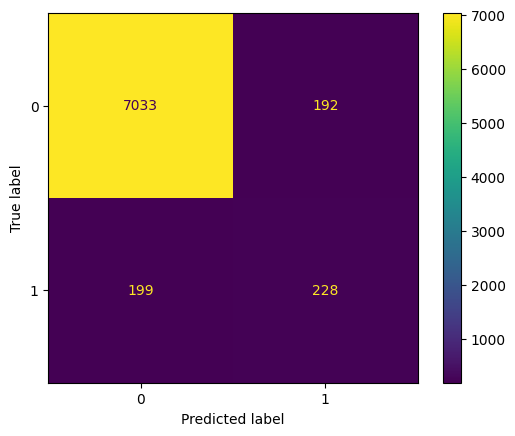

In [82]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

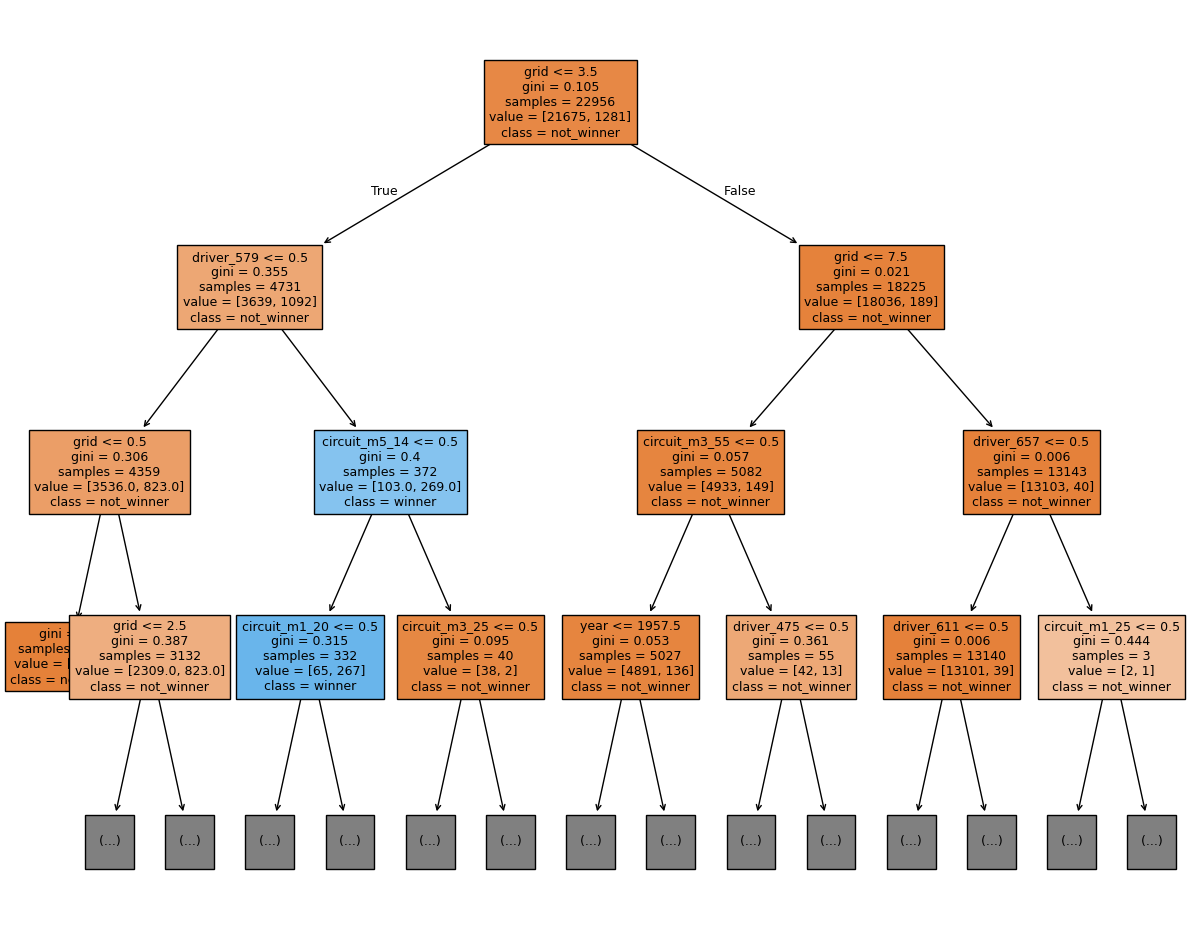

In [83]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=3, fontsize=9, feature_names=X.columns, 
          class_names={0:'not_winner', 1:'winner'}, filled=True);
plt.show()

And so we clearly see from the model that it is rubbish. Somehow it decided that the second most important feature is whether the driver_579 is in the race. Or is it rubbish? Was there a driver so good, that whenever he started from 3rd or lower we was nearly always going to win? Who is this legend?

In [84]:
drivers = pd.read_csv('f1_dataset/drivers.csv')
drivers.loc[drivers['driverId'] == 579]

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
579,579,fangio,\N,\N,Juan,Fangio,1911-06-24,Argentine,http://en.wikipedia.org/wiki/Juan_Manuel_Fangio


Turns out it is Juan Fangio - one of the world's best drivers. He competed in 51 races winning 24 of them - nearly a half! 

## No driver ID

In [85]:
features2 = pd.concat([df, encoded_cicruits, encoded_cicruits_m1, encoded_cicruits_m2, encoded_cicruits_m3, encoded_cicruits_m4, encoded_cicruits_m5, winner],axis=1)
features2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 0 to 30607
Columns: 476 entries, grid to winner
dtypes: float64(464), int64(12)
memory usage: 111.4 MB


In [86]:
short_feats2 = features2.drop(['driverId', 'circuitId', 'position', 'circuitId_m1', 'circuitId_m2', 'circuitId_m3', 'circuitId_m4', 'circuitId_m5'], 
                            axis=1)

In [87]:
# Define the y (target) variable
y = short_feats2['winner']

# Define the X (predictor) variables
X = short_feats2.copy()
X = X.drop('winner', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)

In [88]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [89]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.947
Precision: 0.524
Recall: 0.513
F1 Score: 0.518


By removing the driverId from the dataset we have saved 200Mb and only slightly worsened the F1 score (0.538 vs now 0.518). Let's see what the tree now deems as the two most important features.

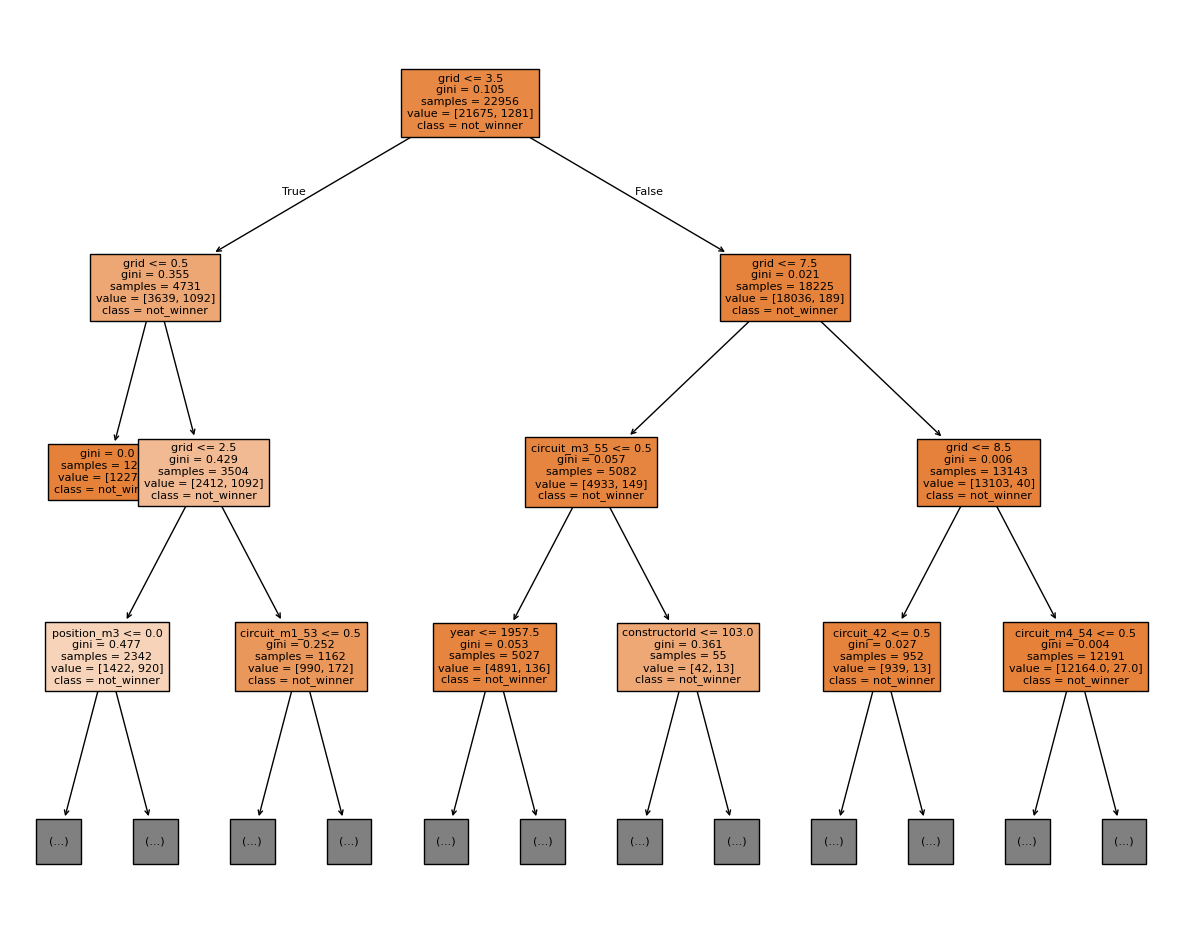

In [90]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=3, fontsize=8, feature_names=X.columns, 
          class_names={0:'not_winner', 1:'winner'}, filled=True);
plt.show()

Rather unsurprisingly it focuses on the starting grid position. Interestingly it still doesnt think that previous form is quite as important as for example some random race track id=55 3 races ago.

## No weather info
and driverId back

In [91]:
short_feats3 = short_feats.drop('rain',axis=1)
short_feats3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 0 to 30607
Columns: 1313 entries, grid to winner
dtypes: float64(1309), int64(4)
memory usage: 306.8 MB


In [92]:
# Define the y (target) variable
y = short_feats3['winner']

# Define the X (predictor) variables
X = short_feats3.copy()
X = X.drop('winner', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.951
Precision: 0.562
Recall: 0.518
F1 Score: 0.539


Ha! Removing rain info has ever so slightly increased the F1 score! Of course lets take it with a pinch of salt. This is a single tree with one particular test/train split. But still - it is not like the scores have crashed down or rocketed sky high. So sounds like we could not only remove driverId but also rain info. But let's hold on - one more variable to test...
## Limit the data to races from 2014 onwards
Why 2014? This is the start of the so-called hybrid era. Just a big and known milestone of F1 development, as good as any.

In [97]:
short_feats4 = short_feats.drop(features[features.year < 2014].index)
short_feats4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3947 entries, 26654 to 30607
Columns: 1314 entries, grid to winner
dtypes: float64(1310), int64(4)
memory usage: 39.6 MB


Yes - we lost 85% of the data. Not fantastic.

In [98]:
# Define the y (target) variable
y = short_feats4['winner']

# Define the X (predictor) variables
X = short_feats4.copy()
X = X.drop('winner', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.918
Precision: 0.224
Recall: 0.265
F1 Score: 0.243
